# 环境导入

In [1]:
import sys
package_root = r"F:\wangpeng\code\transmon-qubit"
sys.path.insert(0, package_root)
print(sys.executable)
%load_ext autoreload
%autoreload 2


C:\Users\QuanmtumYangxx\anaconda3\envs\transmon-qubit\python.exe


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import qutip as qp
import matplotlib as mpl
import scipy
from sklearn.metrics import mean_squared_error
import copy
from chip_hamiltonian.chip_hamiltonian import Chip, ChipDynamic
from solvers.solvers import Solver, SolverDynamic
from experiment import *
from pulse.pulse_lib import *
from functions.plot_tools import PlotTool
from functions.fit_tools import fit_fft
from functions import *
from functions.tools import *
from scipy.optimize import *
from itertools import product

%matplotlib notebook
np.set_printoptions(threshold=np.inf, precision=4, suppress=True)

yaml_path = r'F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\chip_param_2q.yaml'

ploter = PlotTool(figsize=(8, 5), cmap='jet', flag_save=True)

In [54]:
3/np.sqrt(91*82)/2

0.017364554142048415

In [55]:
eta = 3*3/0.5/82
0.5*(1-eta)/91/2

0.0021441972661484857

# BAQ

In [3]:
#
chip = Solver(chip_path=yaml_path, dim=3)
# chip.ZZcoupling(chip.q_dic['C1_2']['w_idle'], 'Q1', 'Q2')
w_off, zz_off = chip.ZZ_min((5, 8), 'Q1', 'Q2', save_flag=True)
print(f'w_off: {w_off} GHz  zz_off: {zz_off*1e6} kHz')
# w2_work0, E_diff = chip.resonate_point('Q2', (4.7, 4.9), (('Q1', 'Q2'), (1, 1)), (('Q1', 'Q2'), (0, 2)))

num_cpus: 16
1
w_off: 7.239756203199996 GHz  zz_off: 20.388955340955306 kHz


In [4]:
cz = CZ(chip_path=yaml_path,
        dim=3,
        QL='Q1',
        QH='Q2',
        flag_fig=True,
        time_step=0.1,
        flag_data=False)

num_cpus: 16
root_path: F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\CZ


## 布局含时演化

In [5]:
exp_args = {
    'shape': 'FlattopGaussian',
    'arg_type': 'wq',
    'sigma': 2,
    'buffer': 10
}
cz.exp_args = exp_args

In [28]:
arg_dic = {'C1_2': 5.125}
evolution_result = cz.run_evolution(arg_dic, 47)


In [49]:
cz.ploter.flag_save = True

False

<IPython.core.display.Javascript object>


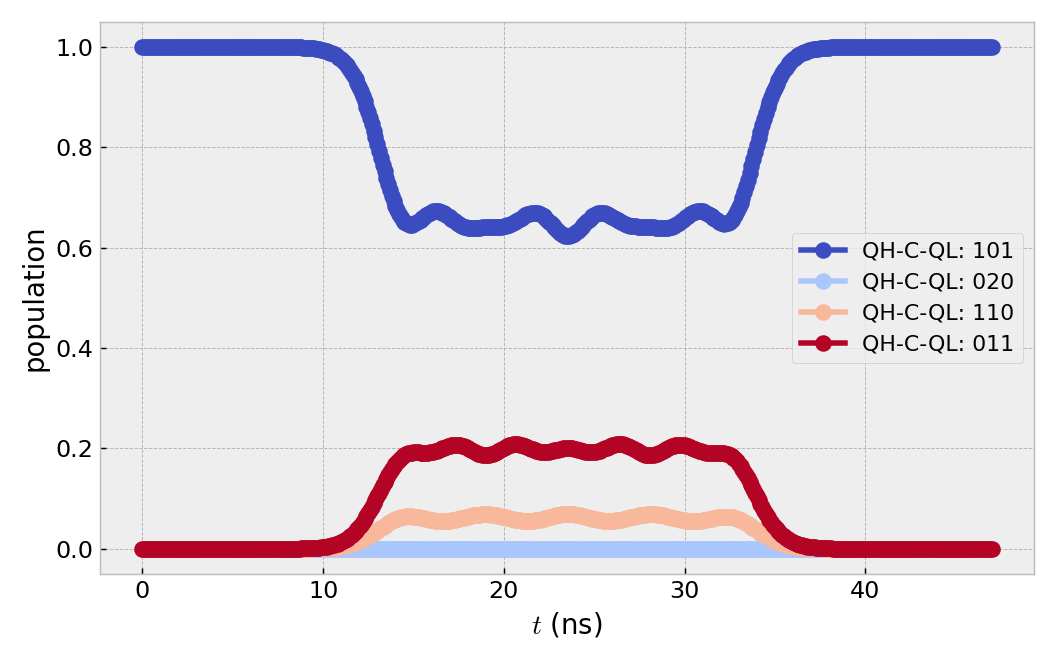

fig path: F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\CZ\2023-09\0924-21.47.42_布局数随时间.png


In [44]:
expec_name_list = ['101', '020', '110', '011']
mea_ops = [
    cz.Od(('Q2', 'C1_2', 'Q1'), (1, 0, 1)),
    cz.Od(('Q2', 'C1_2', 'Q1'), (0, 2, 0)),
    cz.Od(('Q2', 'C1_2', 'Q1'), (1, 1, 0)),
    cz.Od(('Q2', 'C1_2', 'Q1'), (0, 1, 1)),
]
expect_list = qp.expect(mea_ops, evolution_result.states)

fig, ax = plt.subplots()
ax.set_xlabel(r'$t$ (ns)')
ax.set_ylabel(r'population')
custom_color = cz.ploter.cmap(np.linspace(0, 1, len(expec_name_list)))
for i, expec_name in enumerate(expec_name_list):
    label = fr'QH-C-QL: {expec_name}'
    ax.plot(evolution_result.times, expect_list[i], label=label, color=custom_color[i])
ax.legend()
title = fr'布局数随时间'
cz.ploter.save_fig(fig, title)

<IPython.core.display.Javascript object>


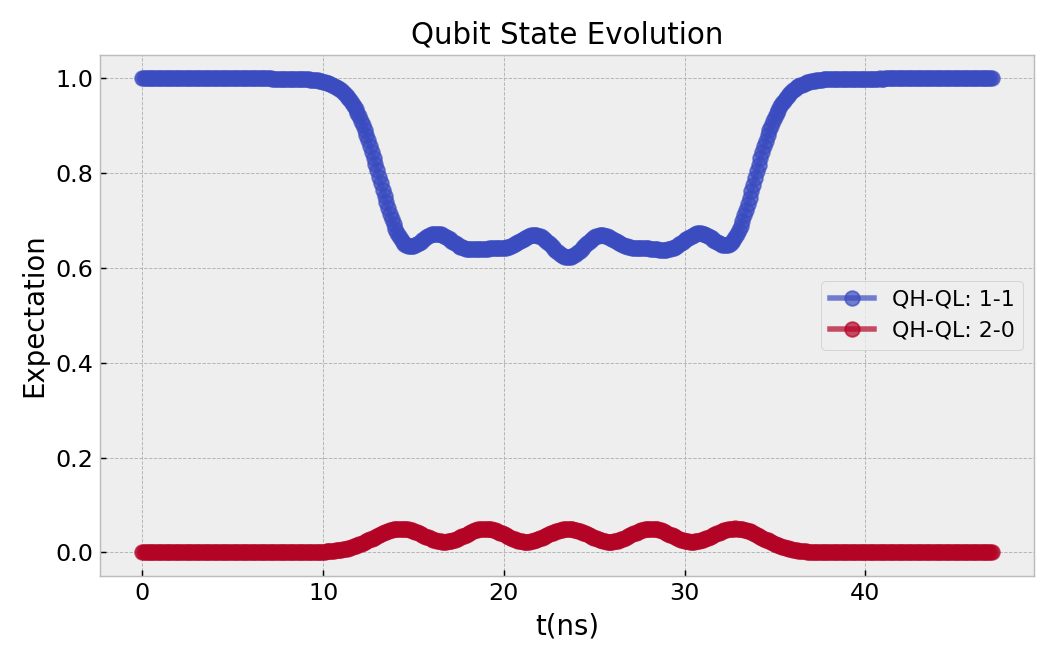

fig path: F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\CZ\2023-09\0924-19.46.24_Qubit State Evolution.png


In [21]:
cz.analyze_evolution()

## 受控相位含时演化

In [45]:
cphase_result = cz.run_cphase(arg_dic, 47)

<IPython.core.display.Javascript object>


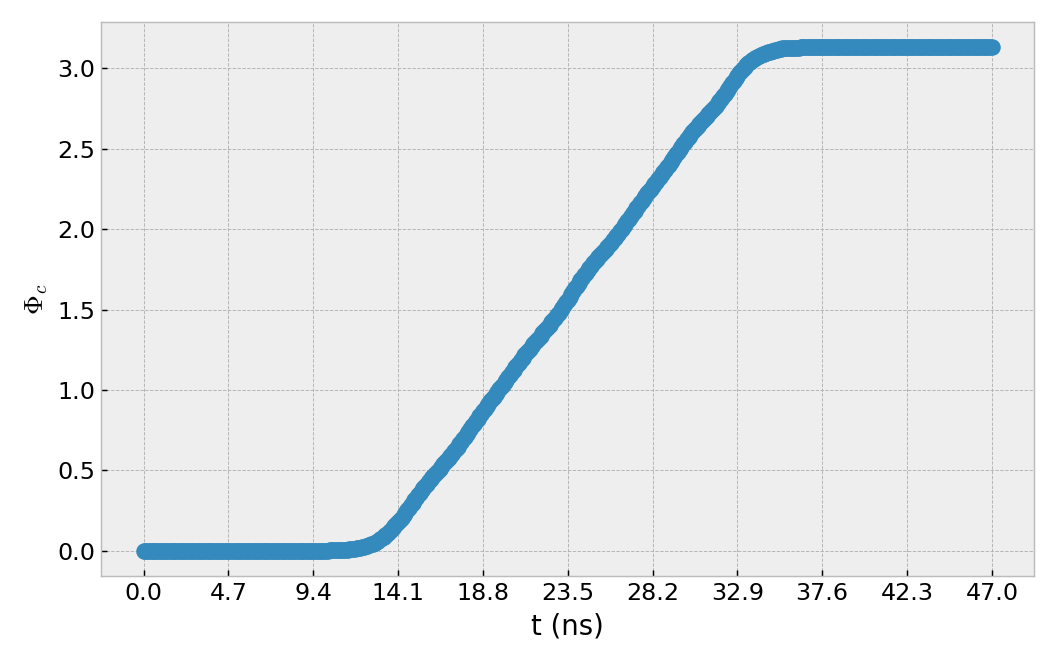

fig path: F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\CZ\2023-09\0924-21.50.54_.png


In [50]:
cphase = cz.analyze_cphase()

## 二维泄露

In [24]:
wc_list = np.linspace(5, 5.6, 41)
arg_dic_list = [{'C1_2': wc} for wc in wc_list]
width_list = np.linspace(30, 60, 31)

evolution_result_list = qp.parallel_map(
    cz.run_evolution,
    list(product(arg_dic_list, width_list)),
    task_kwargs={'parallel_args': ['arg_dic', 'width']},
    progress_bar=True,
    num_cpus=cz.num_cpus)

10.1%. Run time:   8.74s. Est. time left: 00:00:01:18
20.1%. Run time:  12.68s. Est. time left: 00:00:00:50
30.1%. Run time:  17.78s. Est. time left: 00:00:00:41
40.0%. Run time:  21.76s. Est. time left: 00:00:00:32
50.0%. Run time:  26.68s. Est. time left: 00:00:00:26
60.0%. Run time:  30.63s. Est. time left: 00:00:00:20
70.0%. Run time:  34.71s. Est. time left: 00:00:00:14
80.0%. Run time:  39.60s. Est. time left: 00:00:00:09
90.0%. Run time:  43.43s. Est. time left: 00:00:00:04
100.0%. Run time:  47.09s. Est. time left: 00:00:00:00
Total run time:  47.18s


<IPython.core.display.Javascript object>


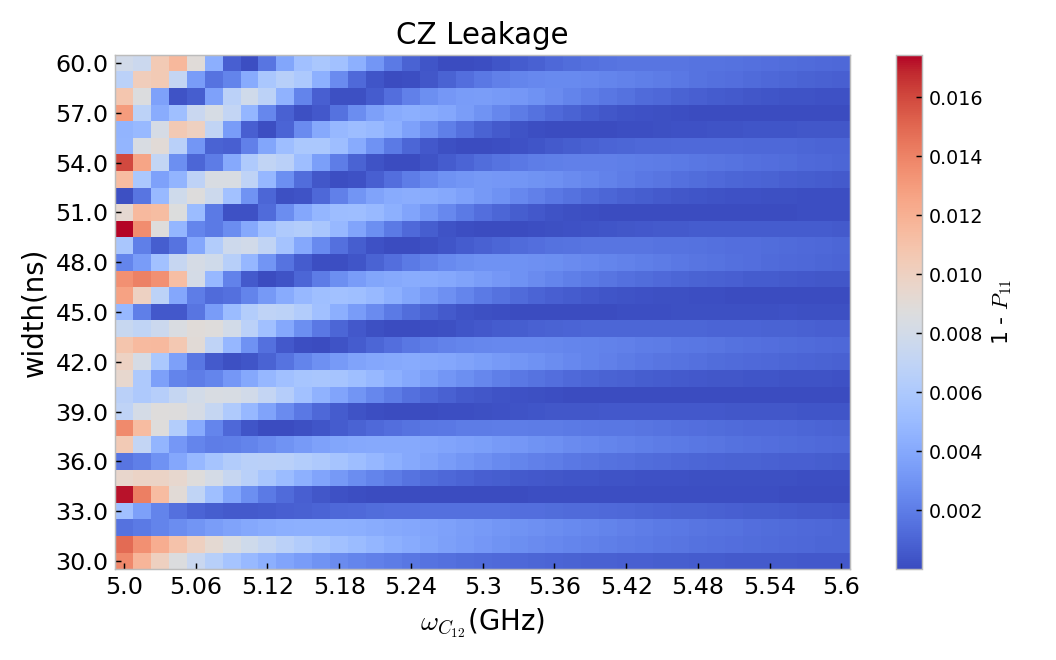

In [27]:
evo_result_list = [
    evolution_result.states[-1] for evolution_result in evolution_result_list
]
mea_ops = cz.Od((cz.QL, cz.QH), (1, 1))
expect_list = qp.expect(mea_ops, evo_result_list)
expect_arr = expect_list.reshape(len(wc_list), len(width_list))
leak_arr = 1 - expect_arr
cz.ploter.plot_heatmap(wc_list,
                       width_list,
                       leak_arr.T,
                       xlabel=r'$\omega_{C_{12}}$',
                       ylabel=r'width',
                       zlabel='1 - $P_{11}$',
                       title=f'CZ Leakage',
)

## 二维受控相位

In [7]:
# wc_list = np.linspace(5, 6, 41)
# arg_dic_list = [{'C1_2': wc} for wc in wc_list]
# width_list = np.linspace(30, 60, 31)

cphase_result_list = qp.parallel_map(
    cz.run_cphase,
    list(product(arg_dic_list, width_list)),
    task_kwargs={'parallel_args': ['arg_dic', 'width']},
    progress_bar=True,
    num_cpus=cz.num_cpus)

10.1%. Run time:  11.09s. Est. time left: 00:00:01:39
20.1%. Run time:  18.24s. Est. time left: 00:00:01:12
30.1%. Run time:  25.42s. Est. time left: 00:00:00:59
40.0%. Run time:  33.06s. Est. time left: 00:00:00:49
50.0%. Run time:  41.18s. Est. time left: 00:00:00:41
60.0%. Run time:  48.43s. Est. time left: 00:00:00:32
70.0%. Run time:  56.36s. Est. time left: 00:00:00:24
80.0%. Run time:  64.05s. Est. time left: 00:00:00:15
90.0%. Run time:  71.71s. Est. time left: 00:00:00:07
100.0%. Run time:  78.60s. Est. time left: 00:00:00:00
Total run time:  78.72s


<IPython.core.display.Javascript object>


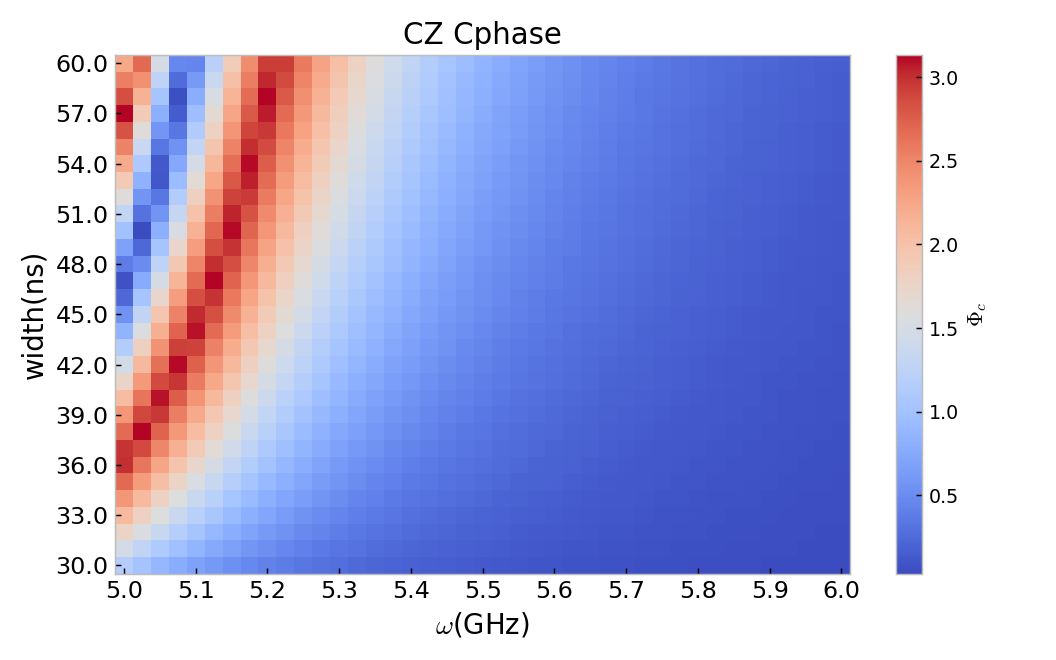

fig path: F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\CZ\2023-09\0924-16.23.10_CZ Cphase.png


In [15]:
cphase_list = [
    cz.analyze_cphase(result, plot_flag=False)[-1]
    for result in cphase_result_list
]
cphase_arr = np.array(cphase_list).reshape(len(wc_list), len(width_list))
cz.ploter.plot_heatmap(
    wc_list,
    width_list,
    cphase_arr.T,
    xlabel=r'$\omega_{C_{12}}$',
    ylabel=r'width',
    zlabel='$\Phi_c$',
    title=f'CZ Cphase')

In [8]:
cz.analyze_cphase(cphase_result_list[0], plot_flag=False)

array([1.1602])

## 二维保真度

In [7]:
error_result_list = qp.parallel_map(cz.fidelity_calculate,
                                    list(product(wc_list, width_list)),
                                    task_kwargs={
                                        'bit_name_list': ['C1_2'],
                                        'parallel_args': ['w_list', 'width']
                                    },
                                    progress_bar=True,
                                    num_cpus=cz.num_cpus-2)

10.1%. Run time:  18.96s. Est. time left: 00:00:02:49
20.1%. Run time:  32.59s. Est. time left: 00:00:02:09
30.1%. Run time:  45.93s. Est. time left: 00:00:01:46
40.0%. Run time:  58.99s. Est. time left: 00:00:01:28
50.0%. Run time:  72.23s. Est. time left: 00:00:01:12
60.0%. Run time:  85.43s. Est. time left: 00:00:00:56
70.0%. Run time:  98.98s. Est. time left: 00:00:00:42
80.0%. Run time: 112.27s. Est. time left: 00:00:00:28
90.0%. Run time: 125.56s. Est. time left: 00:00:00:13
100.0%. Run time: 138.84s. Est. time left: 00:00:00:00
Total run time: 138.93s


<IPython.core.display.Javascript object>


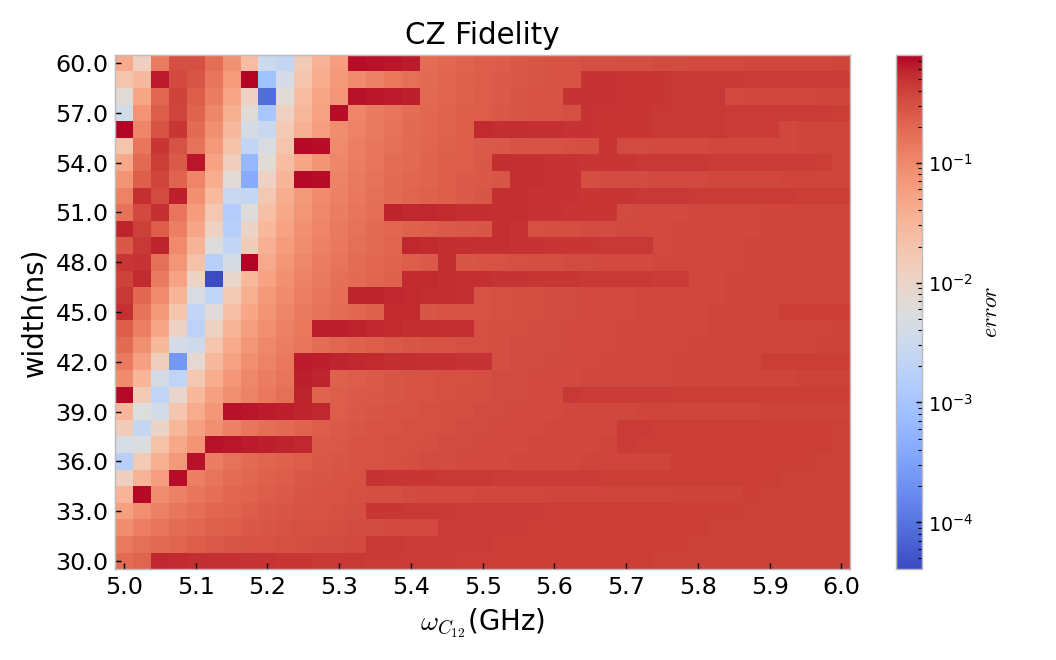

fig path: F:\wangpeng\code\jupyter\transmon-qubit\固定频率可调耦合\CZ\2023-09\0924-16.46.30_CZ Fidelity.png


In [15]:
error_arr = np.array(error_result_list).reshape(len(wc_list), len(width_list))
cz.ploter.plot_heatmap(
    wc_list,
    width_list,
    error_arr.T,
    xlabel=r'$\omega_{C_{12}}$',
    ylabel=r'width',
    zlabel='$error$',
    title=f'CZ Fidelity', norm='log')

In [9]:
r'$\omega_{C_{12}$'

'$\\omega_{C_{12}$'